In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, load_dataset, DatasetDict
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
import numpy as np
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from datasets import Dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
sns.set()

In [71]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [2]:
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 2)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = tf.keras.metrics.SparseCategoricalAccuracy()
)

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deepcontractor/200k-short-texts-for-humor-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/200k-short-texts-for-humor-detection


In [5]:
df = pd.read_csv('/kaggle/input/200k-short-texts-for-humor-detection/dataset.csv')
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [6]:
df.shape

(200000, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.7+ MB


In [8]:
df.isnull().sum()

text     0
humor    0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df['humor'].value_counts()

humor
False    100000
True     100000
Name: count, dtype: int64

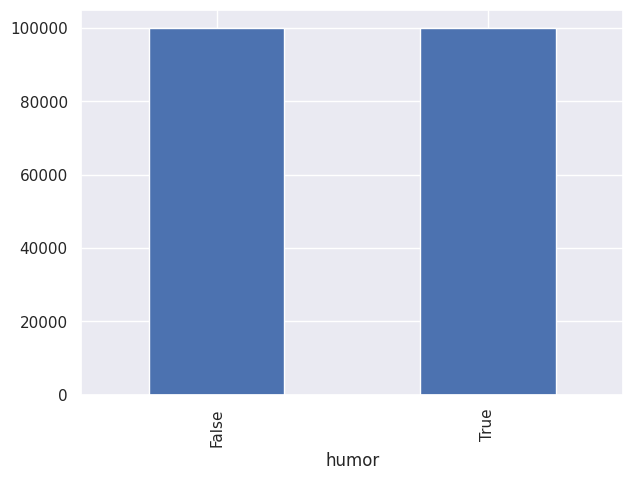

In [11]:
df['humor'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.show()

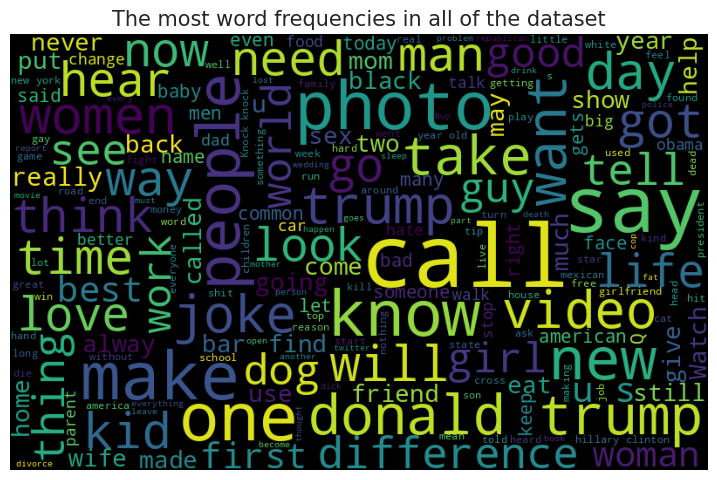

In [12]:
plt.figure(figsize = (9, 7))
all_sent = ' '.join([sentence for sentence in df['text']])
word_cloud_all = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 100).generate(all_sent)
plt.imshow(word_cloud_all)
plt.title('The most word frequencies in all of the dataset', fontsize = 15)
plt.axis('off')
plt.show()

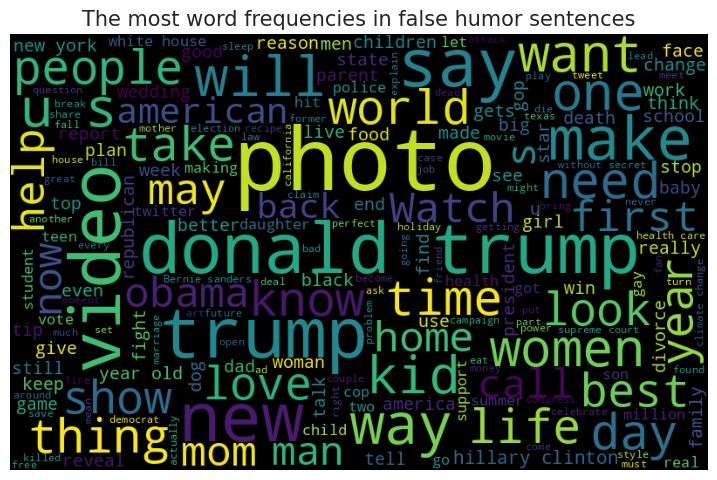

In [13]:
plt.figure(figsize = (9, 7))
false_sent = ' '.join([sentence for sentence in df['text'][df['humor'] == False]])
word_cloud_false = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(false_sent)
plt.imshow(word_cloud_false)
plt.title('The most word frequencies in false humor sentences', fontsize = 15)
plt.axis('off')
plt.show()

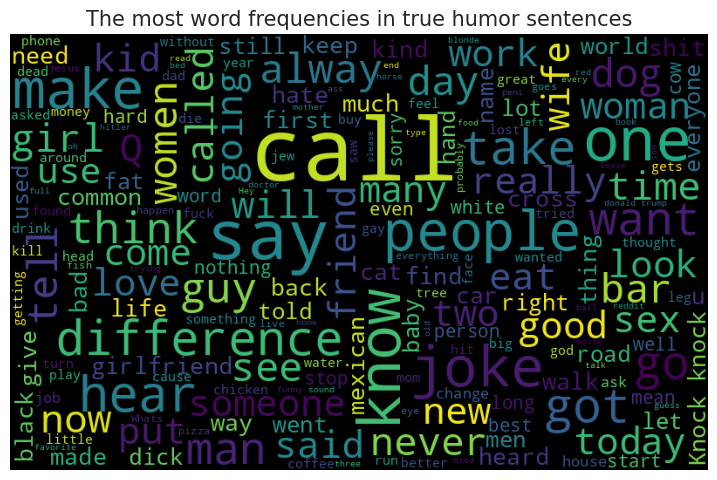

In [14]:
plt.figure(figsize = (9, 7))
true_sent = ' '.join([sentence for sentence in df['text'][df['humor'] == True]])
word_cloud_true = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(true_sent)
plt.imshow(word_cloud_true)
plt.title('The most word frequencies in true humor sentences', fontsize = 15)
plt.axis('off')
plt.show()

In [15]:
df_humor = df[df['humor'] == True].sample(5000)
df_not_humor = df[df['humor'] == False].sample(5000)

In [16]:
df_new = pd.concat([df_humor, df_not_humor])
df_new.head()

,text,humor
93092,"Roses are red, violets are red... actually, i ...",True
141628,You're just jealous because the voices are tal...,True
124402,What does a redhead with a yeast infection lik...,True
175910,My wife called me mean... ... so i called her ...,True
164683,What kind of coat does a vampire wear in the r...,True


In [17]:
df_new.shape

(10000, 2)

In [18]:
df_new.reset_index(drop = True, inplace = True)

In [19]:
df_new.head()

,text,humor
0,"Roses are red, violets are red... actually, i ...",True
1,You're just jealous because the voices are tal...,True
2,What does a redhead with a yeast infection lik...,True
3,My wife called me mean... ... so i called her ...,True
4,What kind of coat does a vampire wear in the r...,True


In [20]:
sw = stopwords.words('english')

In [21]:
def text_cleaning(text):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    words = [word for word in text.split() if word not in sw]
    return ' '.join(words)

In [22]:
df_new['cleaned_text'] = df_new['text'].apply(text_cleaning)

In [23]:
df_new.head()

,text,humor,cleaned_text
0,"Roses are red, violets are red... actually, i ...",True,roses red violets red actually think garden fire
1,You're just jealous because the voices are tal...,True,jealous voices talking
2,What does a redhead with a yeast infection lik...,True,redhead yeast infection like spare time make g...
3,My wife called me mean... ... so i called her ...,True,wife called mean called average
4,What kind of coat does a vampire wear in the r...,True,kind coat vampire wear rain wet one


In [24]:
le = LabelEncoder()

In [25]:
df_new['labels'] = le.fit_transform(df_new['humor'])

In [26]:
df_new.head()

,text,humor,cleaned_text,labels
0,"Roses are red, violets are red... actually, i ...",True,roses red violets red actually think garden fire,1
1,You're just jealous because the voices are tal...,True,jealous voices talking,1
2,What does a redhead with a yeast infection lik...,True,redhead yeast infection like spare time make g...,1
3,My wife called me mean... ... so i called her ...,True,wife called mean called average,1
4,What kind of coat does a vampire wear in the r...,True,kind coat vampire wear rain wet one,1


In [27]:
ds = Dataset.from_pandas(df_new)
ds

Dataset({
    features: ['text', 'humor', 'cleaned_text', 'labels'],
    num_rows: 10000
})

In [28]:
train_test = ds.train_test_split()
test_valid = train_test['test'].train_test_split()
dataset = DatasetDict({
    'train': train_test['train'],
    'test': test_valid['train'],
    'valid': test_valid['test']
})

In [29]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'humor', 'cleaned_text', 'labels'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['text', 'humor', 'cleaned_text', 'labels'],
        num_rows: 1875
    })
    valid: Dataset({
        features: ['text', 'humor', 'cleaned_text', 'labels'],
        num_rows: 625
    })
})

In [30]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [31]:
def tokenization(data):
    return tokenizer(data['cleaned_text'], padding = 'max_length', truncation = True)

In [32]:
tokenized_data = dataset.map(tokenization, batched = True)

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1875 [00:00<?, ? examples/s]

Map:   0%|          | 0/625 [00:00<?, ? examples/s]

In [33]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['text', 'humor', 'cleaned_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['text', 'humor', 'cleaned_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1875
    })
    valid: Dataset({
        features: ['text', 'humor', 'cleaned_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 625
    })
})

In [34]:
print(f'Vocab size is: {tokenizer.vocab_size}')
print(f'Model max length is: {tokenizer.model_max_length}')
print(f'Model input names are: {tokenizer.model_input_names}')

Vocab size is: 28996
Model max length is: 512
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


In [35]:
tokenized_data = tokenized_data.remove_columns(['text', 'humor', 'cleaned_text'])

In [36]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1875
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 625
    })
})

In [37]:
train_set = tokenized_data['train']
test_set = tokenized_data['test']
valid_set = tokenized_data['valid']

In [38]:
train_set

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7500
})

In [39]:
train_set = train_set.with_format('tensorflow')
test_set = test_set.with_format('tensorflow')
valid_set = valid_set.with_format('tensorflow')

In [40]:
train_set

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7500
})

In [41]:
train_features = {x: train_set[x] for x in tokenizer.model_input_names}
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_set['labels']))
train_dataset = train_dataset.shuffle(len(train_set)).batch(8)

In [42]:
test_features = {x: test_set[x] for x in tokenizer.model_input_names}
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_set['labels']))
test_dataset = test_dataset.shuffle(len(test_set)).batch(8)

In [43]:
valid_features = {x: valid_set[x] for x in tokenizer.model_input_names}
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_features, valid_set['labels']))
valid_dataset = valid_dataset.shuffle(len(valid_set)).batch(8)

In [44]:
history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 3)

Epoch 1/3
938/938 [==============================] - 582s 582ms/step - loss: 0.3980 - sparse_categorical_accuracy: 0.8227 - val_loss: 0.2941 - val_sparse_categorical_accuracy: 0.8800
Epoch 2/3
938/938 [==============================] - 544s 580ms/step - loss: 0.2175 - sparse_categorical_accuracy: 0.9193 - val_loss: 0.3030 - val_sparse_categorical_accuracy: 0.8800
Epoch 3/3
938/938 [==============================] - 546s 582ms/step - loss: 0.1150 - sparse_categorical_accuracy: 0.9635 - val_loss: 0.3961 - val_sparse_categorical_accuracy: 0.8736


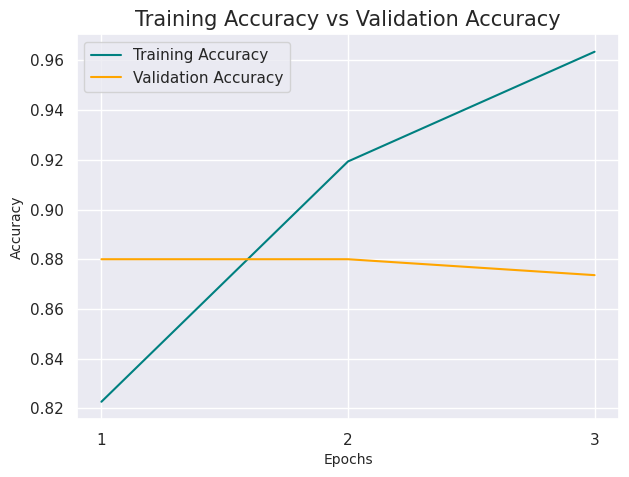

In [49]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['sparse_categorical_accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.xticks(ticks = [0, 1, 2], labels = [1, 2, 3])
plt.legend()
plt.show()

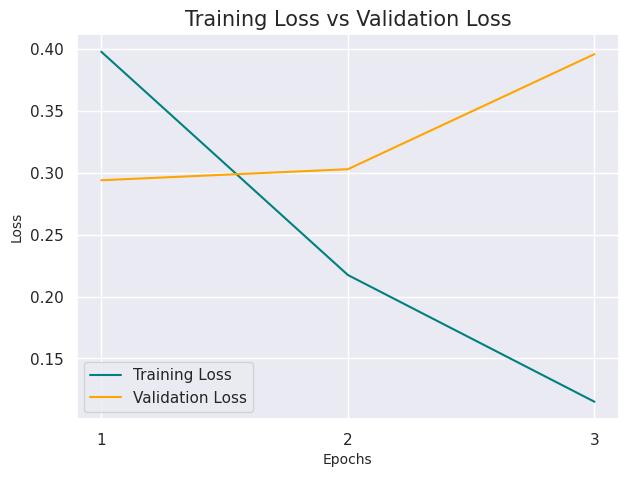

In [50]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.xticks(ticks = [0, 1, 2], labels = [1, 2, 3])
plt.legend()
plt.show()

In [53]:
model.evaluate(test_dataset)

235/235 [==============================] - 47s 200ms/step - loss: 0.3827 - sparse_categorical_accuracy: 0.8763


[0.38266879320144653, 0.8762666583061218]

In [67]:
model2 = TFAutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
model2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-6),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = tf.keras.metrics.SparseCategoricalAccuracy()
)

In [69]:
history2 = model2.fit(train_dataset, validation_data = valid_dataset, epochs = 2)

Epoch 1/2
938/938 [==============================] - 578s 585ms/step - loss: 0.4430 - sparse_categorical_accuracy: 0.7981 - val_loss: 0.3295 - val_sparse_categorical_accuracy: 0.8544
Epoch 2/2
938/938 [==============================] - 545s 581ms/step - loss: 0.2522 - sparse_categorical_accuracy: 0.9001 - val_loss: 0.2896 - val_sparse_categorical_accuracy: 0.8816


In [70]:
model2.evaluate(test_dataset)

235/235 [==============================] - 47s 200ms/step - loss: 0.2921 - sparse_categorical_accuracy: 0.8811


[0.2920861840248108, 0.8810666799545288]

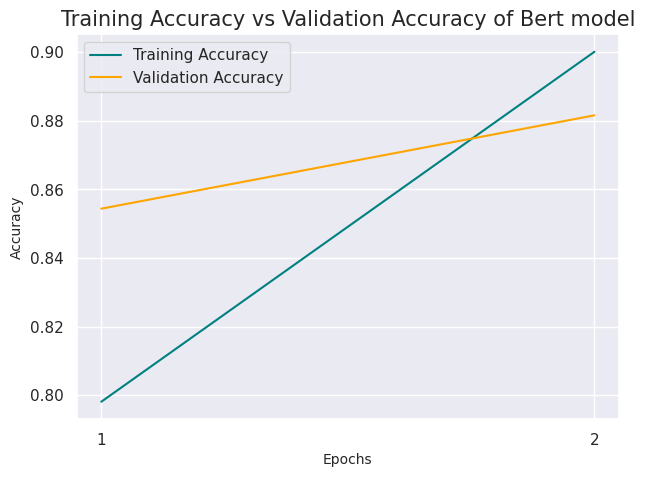

In [118]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['sparse_categorical_accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history2.history['val_sparse_categorical_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy of Bert model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.xticks(ticks = [0, 1], labels = [1, 2])
plt.legend()
plt.show()

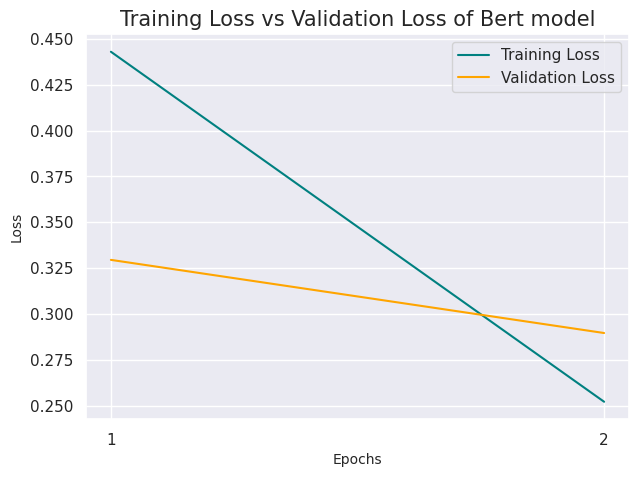

In [119]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history2.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss of Bert model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.xticks(ticks = [0, 1], labels = [1, 2])
plt.legend()
plt.show()

In [72]:
df_new.head()

,text,humor,cleaned_text,labels
0,"Roses are red, violets are red... actually, i ...",True,roses red violets red actually think garden fire,1
1,You're just jealous because the voices are tal...,True,jealous voices talking,1
2,What does a redhead with a yeast infection lik...,True,redhead yeast infection like spare time make g...,1
3,My wife called me mean... ... so i called her ...,True,wife called mean called average,1
4,What kind of coat does a vampire wear in the r...,True,kind coat vampire wear rain wet one,1


In [74]:
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(df_new['cleaned_text'])
seq = tokenizer2.texts_to_sequences(df_new['cleaned_text'])

In [75]:
seq[:10]

[[750, 197, 1601, 197, 287, 40, 2100, 209],
 [2486, 2992, 609],
 [4950, 3740, 2101, 2, 4951, 15, 10, 7366],
 [92, 67, 288, 67, 1058],
 [177, 4952, 877, 182, 1303, 1304, 7],
 [478, 695, 966, 1845],
 [92, 6, 186, 218, 540, 198, 35, 159, 696],
 [322, 415, 1059, 1602, 2487, 108, 2488, 1435],
 [816, 697, 816, 231, 2993, 7367],
 [262, 1305, 2994, 1183, 27, 47, 102, 70, 751, 1184, 507]]

In [76]:
maxlen = max([len(i) for i in seq])
maxlen

15

In [77]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')
pad_seq

array([[  750,   197,  1601, ...,     0,     0,     0],
       [ 2486,  2992,   609, ...,     0,     0,     0],
       [ 4950,  3740,  2101, ...,     0,     0,     0],
       ...,
       [ 4868,    65, 15104, ...,     0,     0,     0],
       [   15,  1005,   647, ...,     0,     0,     0],
       [15106,    93,  2475, ...,     0,     0,     0]], dtype=int32)

In [78]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anmolkumar/glove-embeddings")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/glove-embeddings


In [79]:
embedding_matrix = dict()
glove_file = open('/kaggle/input/glove-embeddings/glove.6B.100d.txt', encoding = 'utf8')
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:])
    embedding_matrix[word] = vector
glove_file.close()

In [80]:
embedding_matrix['the']

array(['-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172',
       '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459',
       '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231',
       '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336',
       '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971',
       '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722',
       '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397',
       '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531',
       '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477',
       '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205',
       '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167',
       '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079',
       '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044',
       '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972',
       '0.15006', '-0.53212', '

In [81]:
vocab_size = len(tokenizer2.word_index) + 1
vocab_size

15107

In [82]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer2.word_index.items():
    vec = embedding_matrix.get(word)
    if vec is not None:
        embedding_vectors[index] = vec

In [83]:
embedding_vectors

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-0.15731 , -0.75503 ,  0.36845 , ..., -0.54137 ,  0.67817 ,
        -0.17251 ],
       [-0.2687  ,  0.81708 ,  0.69896 , ..., -0.4011  ,  0.74657 ,
         0.31122 ],
       ...,
       [ 0.030872, -0.22622 ,  0.10229 , ...,  0.19966 , -0.35183 ,
         0.02026 ],
       [-0.34327 , -0.52064 ,  0.47792 , ...,  0.45899 , -0.075803,
         0.99315 ],
       [-0.36178 ,  0.056485,  0.56685 , ..., -0.25561 ,  1.0063  ,
         0.26797 ]])

In [84]:
y = df_new['labels']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(pad_seq, y, test_size = 0.2, random_state = 101, shuffle = True,
                                                   stratify = y)

In [86]:
print('The size of training set is:', len(X_train))
print('The size of test set is:', len(X_test))

The size of training set is: 8000
The size of test set is: 2000


In [94]:
model3 = Sequential()

In [95]:
model3.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model3.add(Bidirectional(LSTM(15)))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation = 'sigmoid'))

In [96]:
model3.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [97]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [98]:
history3 = model3.fit(X_train, y_train, epochs = 100, validation_split = 0.1, callbacks = [early_stopping])

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6542 - loss: 0.6089 - val_accuracy: 0.8363 - val_loss: 0.3956
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8271 - loss: 0.3986 - val_accuracy: 0.8425 - val_loss: 0.3739
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8427 - loss: 0.3729 - val_accuracy: 0.8487 - val_loss: 0.3612
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8507 - loss: 0.3507 - val_accuracy: 0.8475 - val_loss: 0.3624
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8738 - loss: 0.3097 - val_accuracy: 0.8512 - val_loss: 0.3484
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8705 - loss: 0.3107 - val_accuracy: 0.8487 - val_loss: 0.3605
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8848 - loss: 0.2869 - val_accuracy: 0.8413 - val_loss: 0.3485


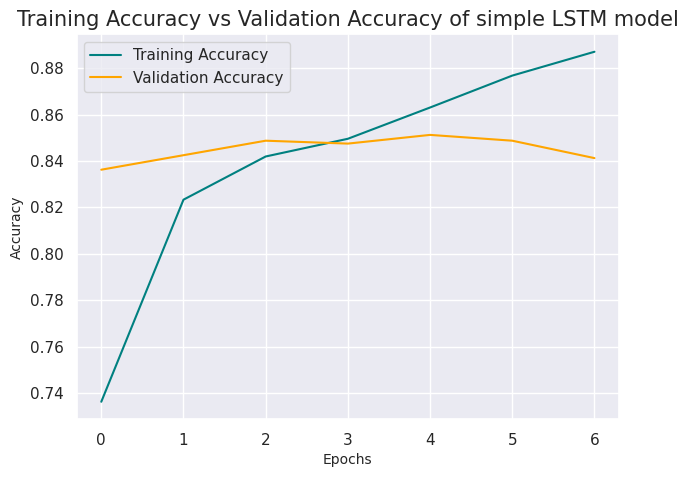

In [99]:
plt.figure(figsize = (7, 5))
plt.plot(history3.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history3.history['val_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation Accuracy of simple LSTM model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

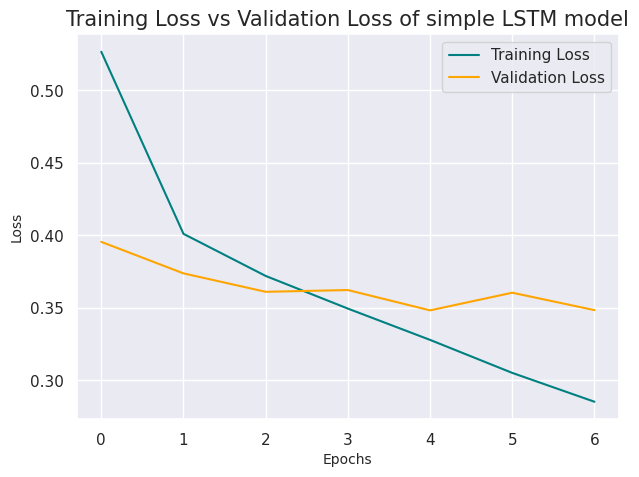

In [100]:
plt.figure(figsize = (7, 5))
plt.plot(history3.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history3.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss of simple LSTM model', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [101]:
model3.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8410 - loss: 0.3683


[0.37884098291397095, 0.8370000123977661]

In [109]:
y_pred = model3.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [110]:
y_pred[0]

array([0.05970636], dtype=float32)

In [111]:
y_p = np.where(y_pred > 0.5, 1, 0)

In [112]:
y_p[0]

array([0])

In [113]:
y_pred[: 10]

array([[0.05970636],
       [0.9948913 ],
       [0.6726904 ],
       [0.98229915],
       [0.98704773],
       [0.812157  ],
       [0.01756903],
       [0.9733184 ],
       [0.03616911],
       [0.04538697]], dtype=float32)

In [114]:
y_p[: 10]

array([[0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0]])

In [115]:
print(classification_report(y_test, y_p))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.85      0.81      0.83      1000

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



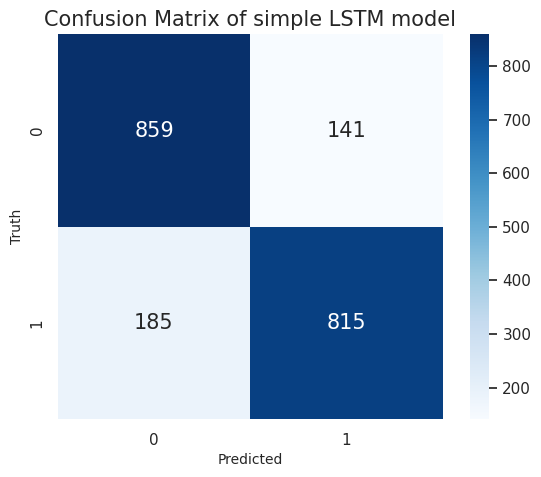

In [116]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(y_test, y_p), annot = True, square = True, cbar = True, fmt = 'd', annot_kws = {'size': 15},
           cmap = 'Blues')
plt.title('Confusion Matrix of simple LSTM model', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()